<a href="https://colab.research.google.com/github/lauraredmondson/nma-eggplant-cobra/blob/master/BOOTSTRAPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import keras
from keras import layers
from keras import models
from keras.applications import ResNet152V2, VGG16, VGG19
from scipy.io import loadmat
from scipy.stats import spearmanr, zscore
import matplotlib.pyplot as plt
import urllib
import os

%matplotlib inline

In [ ]:
#@title Helper Functions
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

  Returns:
    ndarray: S x S representational dissimilarity matrix
  """

  # z-score responses to each stimulus
  zresp = zscore(resp,axis=1)

  # Compute RDM
  RDM = 1 - (zresp@zresp.T)/zresp.shape[1]

  return RDM
  
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1

  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2

  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  #corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  corr_coef = spearmanr(rdm1_offdiag.flatten(), rdm2_offdiag.flatten())[0]
  return corr_coef

def digitize_rdm(rdm_raw, n_bins = 10): 
  """Digitize an input matrix to n bins (10 bins by default)
  rdm_raw: a square matrix 
  """
  # compute the bins 
  
  rdm_bins = [np.percentile(np.ravel(rdm_raw), 100/n_bins * i) for i in range(n_bins)]
  # Compute the vectorized digitized value 
  rdm_vec_digitized = np.digitize(np.ravel(rdm_raw), bins = rdm_bins) * (100 // n_bins) 
  
  # Reshape to matrix
  rdm_digitized = np.reshape(rdm_vec_digitized, np.shape(rdm_raw)) 
  
  # Force symmetry in the plot
  rdm_digitized = (rdm_digitized + rdm_digitized.T) / 2
  
  return rdm_digitized

  def bootstrapping(a, func, n=100, ci=[2.5,97.5]):
    bootstraps = np.zeros(n)
    sample_size = len(a)
    for i in range(n):
      bootstraps[i] = func(np.random.choice(a, len(a), replace=True))
    bootstrap_mean = np.mean(bootstraps)
    bootstrap_ci = np.percentile(bootstraps,ci)

  return bootstrap_mean, bootstrap_ci


def pairs_bootstrapping(a, b, func, n=100, ci=[2.5, 97.5]):
  bootstraps = np.zeros(n)
  sample_size = len(a)

  for i in range(n):
    idx = np.random.choice(range(sample_size), sample_size,replace=True)
    bootstraps[i] = func(a[idx],b[idx])

  bootstrap_mean = np.mean(bootstraps)
  bootstrap_ci = np.percentile(bootstraps,ci)

  return bootstrap_mean, bootstrap_ci

def testfunc(a,b):
  return spearmanr(a,b)[0]

In [ ]:
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)  


In [ ]:
# extract variables
test = loadmat('y_test.mat')
train = loadmat('y_train.mat')

y_train = train["y_train"]
y_test = test["y_test"]
x_train = dat["stimuli"]
x_test = dat["stimuli_test"]

sort_ids = np.argsort(y_train,axis=0)

In [ ]:
# Preprocessing

# subtract mean, divide by standard deviation, add axis 
# one-hot array 

x_train= x_train.astype('float32')   #currently X matrices are of data type int: need to convert here to stop python from complaining when we divide
x_train -= np.mean(x_train)           #deduct the mean: now mean == 0
x_train /= np.std(x_train)            #divide by the std: now std == 1
x_train = np.expand_dims(x_train, -1) #add an extra dimension because our Conv2D layer wills it so

x_test = x_test.astype('float32')     #see above
x_test -= np.mean(x_test)
x_test /= np.std(x_test)
x_test = np.expand_dims(x_test, -1)

x_train = np.tile(x_train, 3)
x_test = np.tile(x_test, 3)

y_train -= 1
y_test -= 1

y_train = keras.utils.to_categorical(y_train, 8) #turn our y vectors (currently ints 0-9) into 'one-hot' vectors to match the categorical output of our network
y_test = keras.utils.to_categorical(y_test, 8)

In [ ]:
conv_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3),
)

In [ ]:
layers = [3, 6, 11, 16, 21]
rois = dat["roi_names"]
cnn_rdm_dict = {}
mri_rdm_dict = {}


# for layer in layers:
#   model = models.Model(inputs=conv_base.get_input_at(0), outputs= conv_base.layers[layer].output)
#   activations = model.predict(x_train[sort_ids].squeeze()).reshape(1750,-1)
#   cnn_rdm_dict[layer] = RDM(activations)
#   model = None
#   activations = None

for idx in range(1,8):
  roi = dat["roi_names"][idx]
  activations = dat['responses'][sort_ids,dat['roi']==idx]
  mri_rdm_dict[roi] = RDM(activations)
  activations = None

NameError: ignored

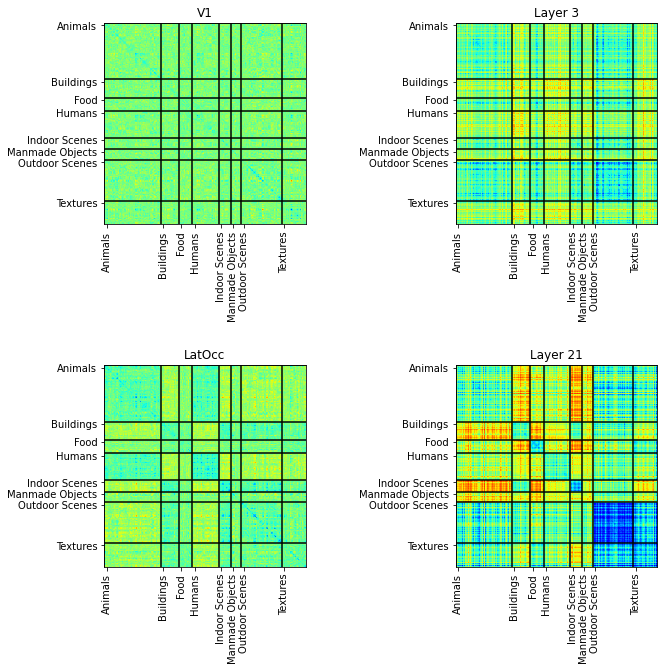

In [ ]:
#@title Run me to see some RSAs!
fig, ax = plt.subplots(2,2, figsize = (10,10))
plt.subplots_adjust(hspace = 0.7, wspace = 0.7)
plt.set_cmap('jet')
categories = ['Animals', 'Buildings', 'Food', 'Humans', 'Indoor Scenes', 'Manmade Objects', 'Outdoor Scenes', 'Textures']
binsize = np.histogram(train['y_train'], 8)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax[0,0].imshow(digitize_rdm(mri_rdm_dict['V1']))
ax[0,0].set_title('V1')
ax[0,1].imshow(digitize_rdm(cnn_rdm_dict[3]))
ax[0,1].set_title('Layer 3')
ax[1,0].imshow(digitize_rdm(mri_rdm_dict['LatOcc']))
ax[1,0].set_title('LatOcc')
ax[1,1].imshow(digitize_rdm(cnn_rdm_dict[21]))
ax[1,1].set_title('Layer 21')

ax = ax.flatten()
for a in ax:
  a.set_xticks(list(np.array(edges)+20))
  a.set_xticklabels(categories, rotation = 90)
  a.set_yticks(list(np.array(edges)+20))
  a.set_yticklabels(categories)
  a.vlines(edges,0,1749)
  a.hlines(edges,0,1749)

fig.show()

In [ ]:
corrs = np.zeros(5)
corr_cis = np.zeros((5,2))
for idx, layer in enumerate(layers):
  print(f"comparison between layer {layer} and Lateral Occipital Cortex:")
  corrs[idx], corr_cis[idx,:] = pairs_bootstrapping(cnn_rdm_dict[layer], mri_rdm_dict['LatOcc'], correlate_rdms, 100)
  print(f"bootstrapped spearman's r: {corrs[idx]:.3f}. \n 95% confidence intervals: {corr_cis[idx,0]:.3f} and {corr_cis[idx,1]:.3f}")

comparison between layer 3 and Lateral Occipital Cortex:
bootstrapped spearman's r: 0.012. 
 95% confidence intervals: 0.009 and 0.015
comparison between layer 6 and Lateral Occipital Cortex:
bootstrapped spearman's r: 0.023. 
 95% confidence intervals: 0.020 and 0.027
comparison between layer 11 and Lateral Occipital Cortex:
bootstrapped spearman's r: 0.033. 
 95% confidence intervals: 0.029 and 0.037
comparison between layer 16 and Lateral Occipital Cortex:
bootstrapped spearman's r: 0.033. 
 95% confidence intervals: 0.029 and 0.037
comparison between layer 21 and Lateral Occipital Cortex:
bootstrapped spearman's r: 0.040. 
 95% confidence intervals: 0.036 and 0.044


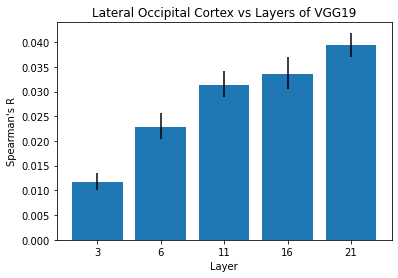

In [ ]:
xpos = np.arange(len(vals))

vals = corrs
yerr = corr_cis.T

fig = plt.figure()
plt.bar(xpos,vals)
plt.xticks(xpos, layers)
plt.xlabel('Layer')
plt.ylabel("Spearman's R")
plt.title("Lateral Occipital Cortex vs Layers of VGG19")
plt.errorbar(xpos,vals,np.abs(yerr-vals), color='black', fmt='none')
plt.show()

example results:

LOC VS:

layer 3: (0.011813171826142235, array([0.01051085, 0.01319015])

layer 6: (0.02042996826145875, array([0.01909702, 0.0217501 ])

layer 11: (0.031163976293563933, array([0.02958641, 0.03245406])

layer 16: (0.027755205812454716, array([0.02626401, 0.02934133])

layer 21: (0.03891228063279218, array([0.03758675, 0.04082912])

Layer 21 VS:

V1: 0.038519476369764584, array([0.03463879, 0.04174799])

V2: 0.03578134997304181, array([0.03265557, 0.03846043])

V3: 0.027105503614878085, array([0.02473316, 0.02931468])

V3a: 0.02011897808662333, array([0.01748892, 0.02339596])

V3b: 0.030333081512931914, array([0.02696602, 0.03331057])

V4: 0.0365333157887806, array([0.03395555, 0.03989385])

LatOcc: 0.0405423241935974, array([0.0366319 , 0.04520912])

V1 VS:

Layer 3: (0.055300597663769976, array([0.04797445, 0.06177862]))

Layer 6: (0.07635684365165703, array([0.07082488, 0.08154281]))

Layer 11: (0.07159046421754703, array([0.06696462, 0.0753394 ]))

Layer 16: (0.05261475897726894, array([0.04732912, 0.05723564]))

Layer 21: (0.038350356327021315, array([0.03477237, 0.04208893]))


In [ ]:
print(pairs_bootstrapping(np.random.randn(1500000),np.random.randn(1500000),testfunc))

(-0.0005871638035092084, array([-0.00213791,  0.00070105]))
